In [1]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import pandas as pd

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION_v2"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## load Database

In [2]:
signals, annotations, signalsMetadata = loadCOGNITIONSpindles_v2(cognipath,returnSignals=True)

In [3]:
annotations

,subjectId,channel,startTime,stopTime,duration,phase,type,samplerate,startInd,stopInd
0,COG001,F3,1798.073930,1798.696491,0.622561,2,spindle,200,359615,359739
1,COG001,F3,1868.599222,1869.591433,0.992211,2,spindle,200,373720,373918
2,COG001,F3,1914.163425,1915.369645,1.206220,2,spindle,200,382833,383074
3,COG001,F3,1916.653694,1917.840459,1.186765,2,spindle,200,383331,383568
4,COG001,F3,1928.638133,1929.902718,1.264585,2,spindle,200,385728,385981
...,...,...,...,...,...,...,...,...,...,...
14684,COG009,C4,35328.677042,35329.338519,0.661477,3,spindle,200,7065735,7065868
14685,COG009,C4,35440.817120,35441.575876,0.758756,3,spindle,200,7088163,7088315
14686,COG009,C4,35521.498055,35522.373535,0.875480,3,spindle,200,7104300,7104475
14687,COG009,C4,39504.552529,39505.077815,0.525286,3,spindle,200,7900911,7901016


(array([2058., 4605., 3723., 2061., 1201.,  556.,  290.,  126.,   51.,
          18.]),
 array([0.447467 , 0.7081683, 0.9688696, 1.2295709, 1.4902722, 1.7509735,
        2.0116748, 2.2723761, 2.5330774, 2.7937787, 3.05448  ]),
 <BarContainer object of 10 artists>)

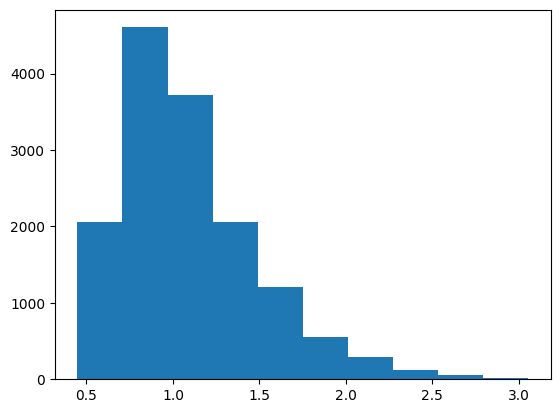

In [4]:
plt.hist(annotations.duration)

## spindle duration histograms

In [5]:
spindles=annotations[annotations.type=='spindle'].copy()

In [6]:
len(spindles)

14689

In [13]:
print("spindles longer than 3s: "+ str(np.sum(spindles.duration>3)))

print("longest spindle (s): "+str(np.max(spindles.duration)))

spindles longer than 3s: 3
longest spindle (s): 3.05448


In [19]:
aux=annotations[["type","subjectId","channel"]].groupby(["type","subjectId","channel"],as_index=False).size()
px.bar(aux,x="subjectId",y="size",color="channel",barmode="group",facet_row="type",title="COGNITION annotations overview")

In [20]:
px.histogram(spindles,x='duration',title="COGNITION spindle duration histogram")

In [23]:
px.histogram(spindles,x='duration',color="subjectId",facet_col="channel",title="COGNITION spindle duration histogram by signal")

### Spindle density by channel

In [60]:
aux=spindles[['subjectId','channel','startTime']].groupby(['subjectId','channel'],as_index=False).size()
aux

,subjectId,channel,size
0,COG001,C3,214
1,COG001,C4,232
2,COG001,F3,984
3,COG001,F4,853
4,COG002,C3,240
5,COG002,C4,110
6,COG002,F3,173
7,COG002,F4,102
8,COG003,C3,849
9,COG003,C4,1162


In [61]:
aux=pd.merge(signalsMetadata,aux,on=["subjectId","channel"])
aux["density"]=aux["size"]/(aux["duration"]/3600)

In [62]:
aux

,filename,subjectId,channel,duration,samplerate,isOriginalSamplerate,database,size,density
0,COG001_F3.pkl,COG001,F3,39600.0,200,False,COGNITION_v2,984,89.454545
1,COG001_C3.pkl,COG001,C3,39600.0,200,False,COGNITION_v2,214,19.454545
2,COG001_F4.pkl,COG001,F4,39600.0,200,False,COGNITION_v2,853,77.545455
3,COG001_C4.pkl,COG001,C4,39600.0,200,False,COGNITION_v2,232,21.090909
4,COG002_F3.pkl,COG002,F3,39600.0,200,False,COGNITION_v2,173,15.727273
5,COG002_C3.pkl,COG002,C3,39600.0,200,False,COGNITION_v2,240,21.818182
6,COG002_F4.pkl,COG002,F4,39600.0,200,False,COGNITION_v2,102,9.272727
7,COG002_C4.pkl,COG002,C4,39600.0,200,False,COGNITION_v2,110,10.000000
8,COG003_F3.pkl,COG003,F3,39600.0,200,False,COGNITION_v2,338,30.727273
9,COG003_C3.pkl,COG003,C3,39600.0,200,False,COGNITION_v2,849,77.181818


C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_15932\2630994023.py:14: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_15932\2630994023.py:15: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_15932\2630994023.py:14: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the va

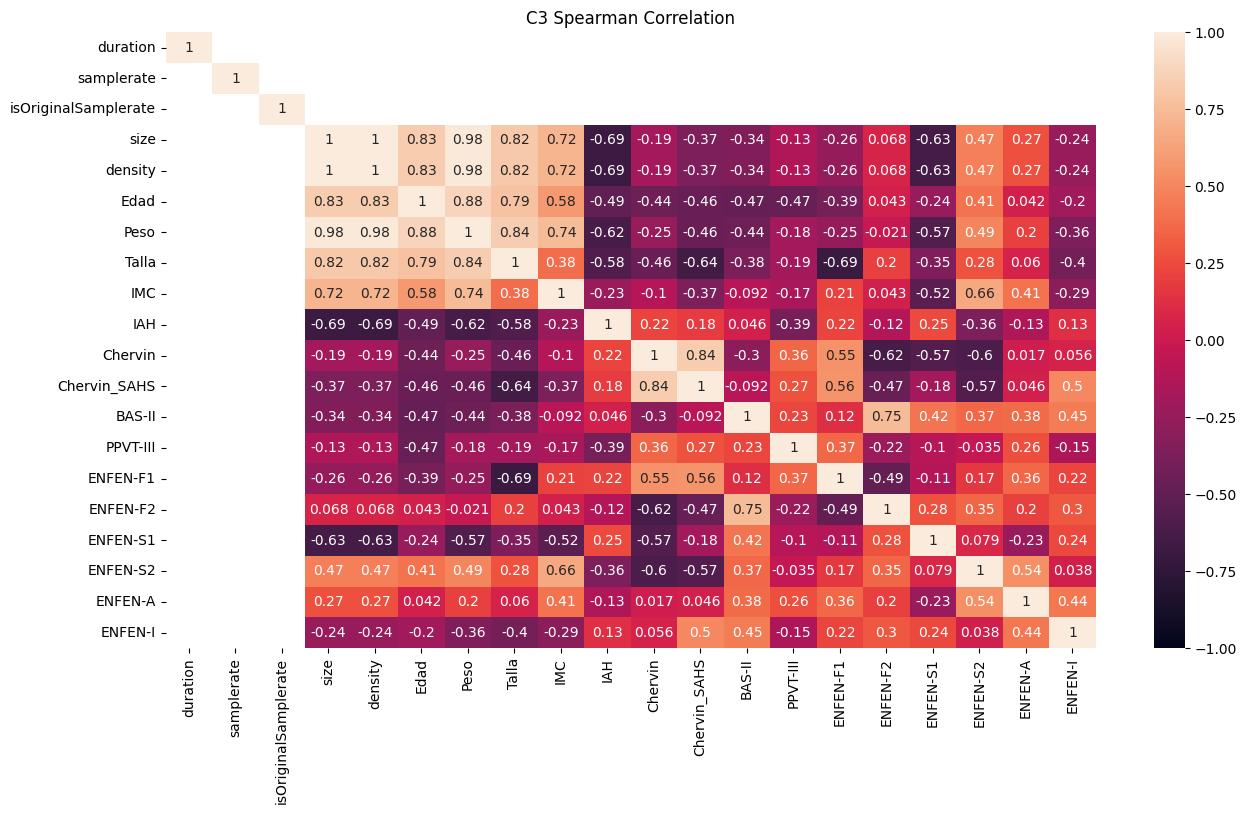

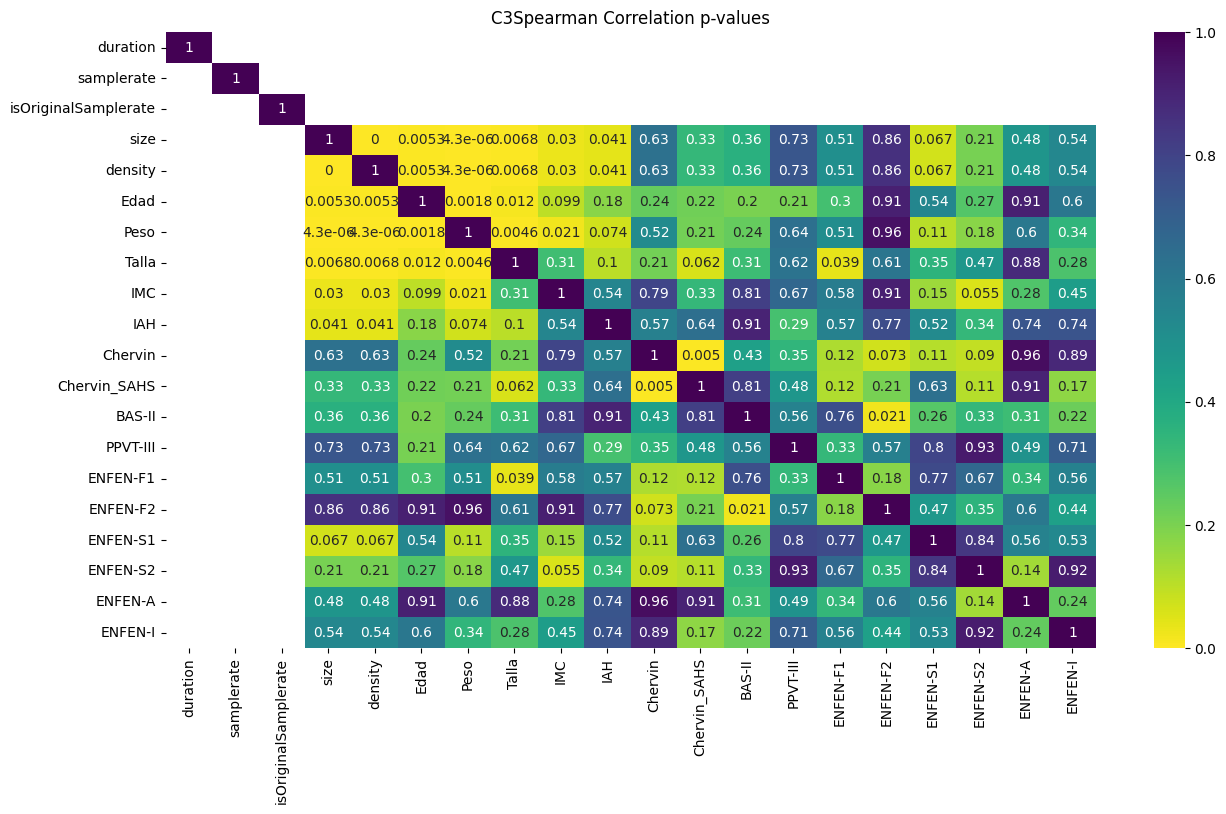

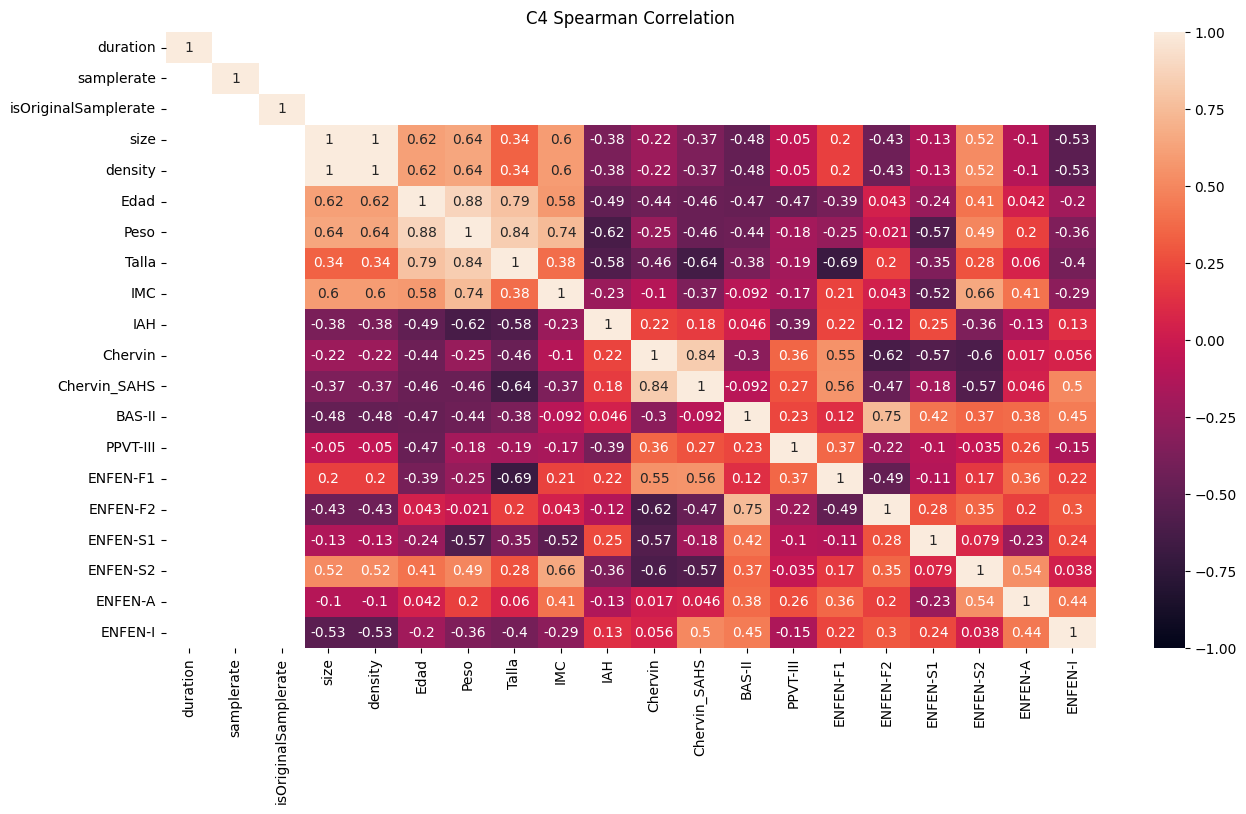

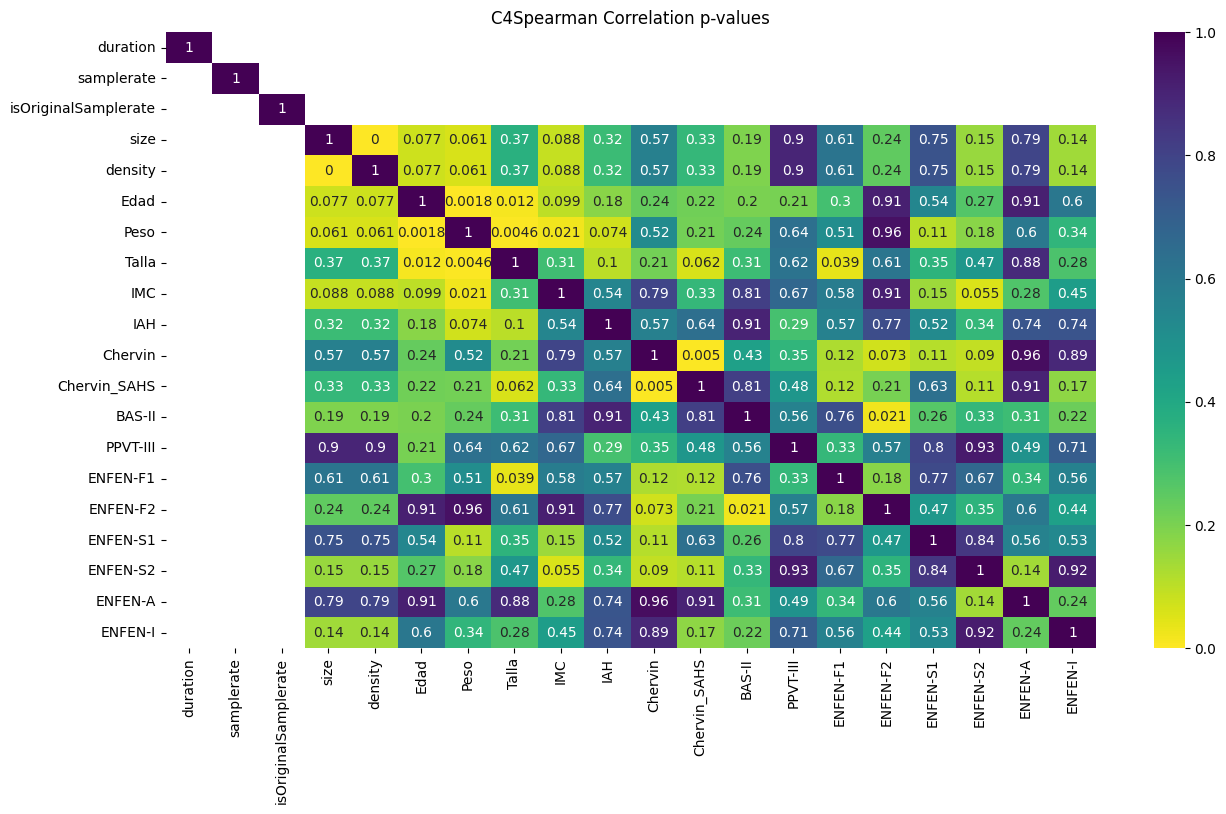

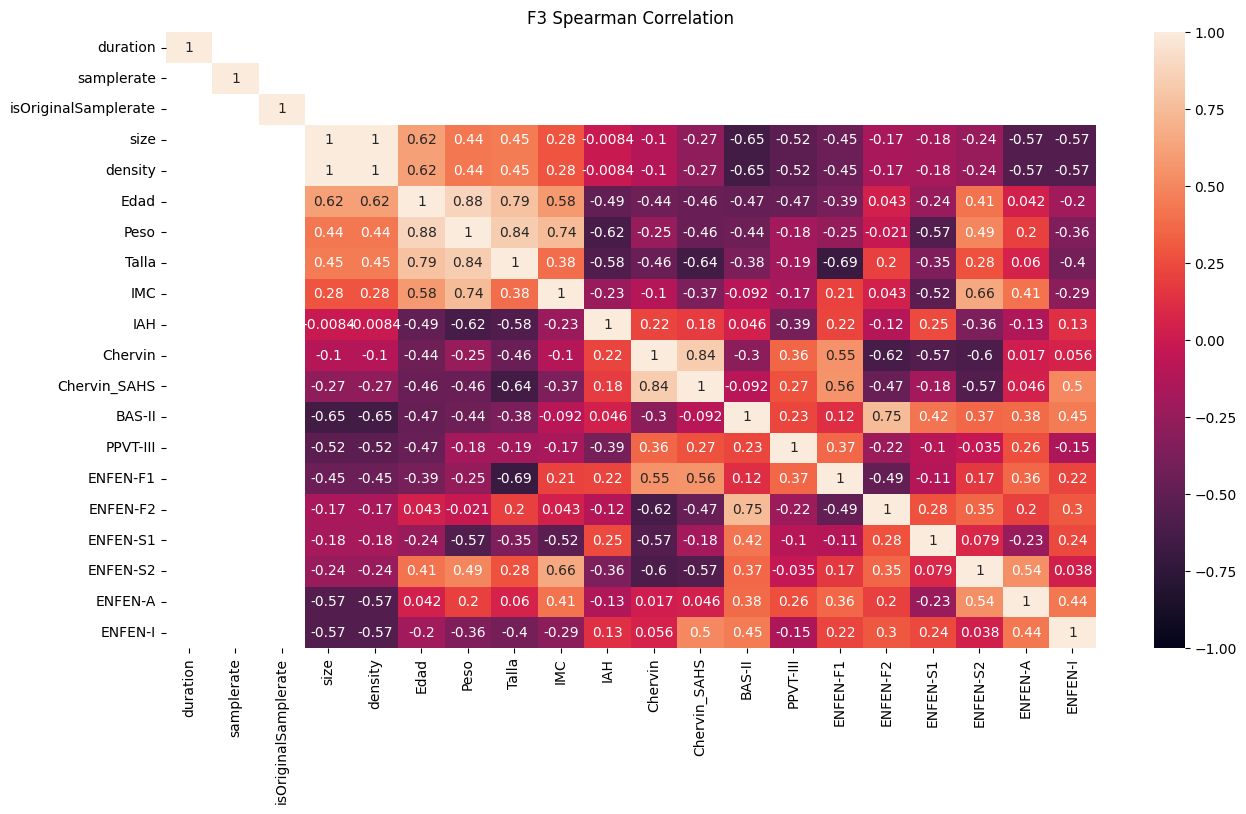

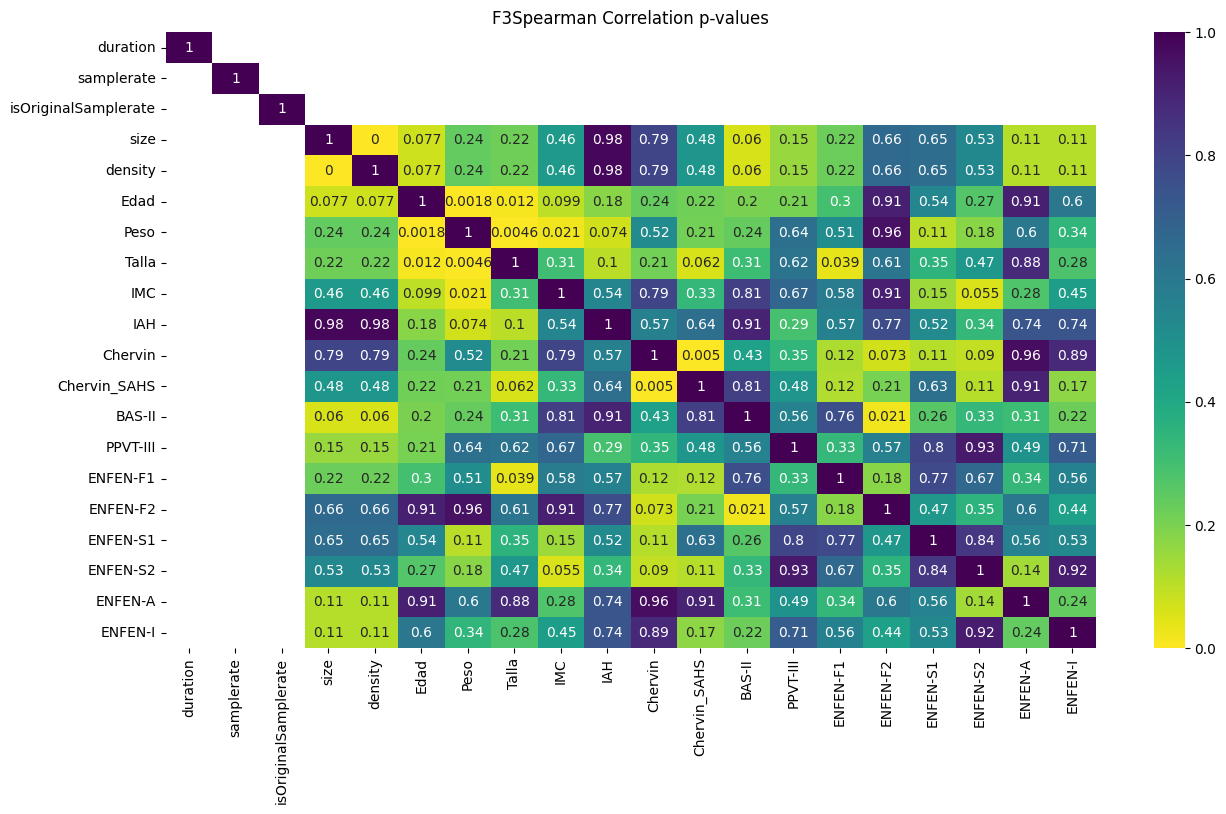

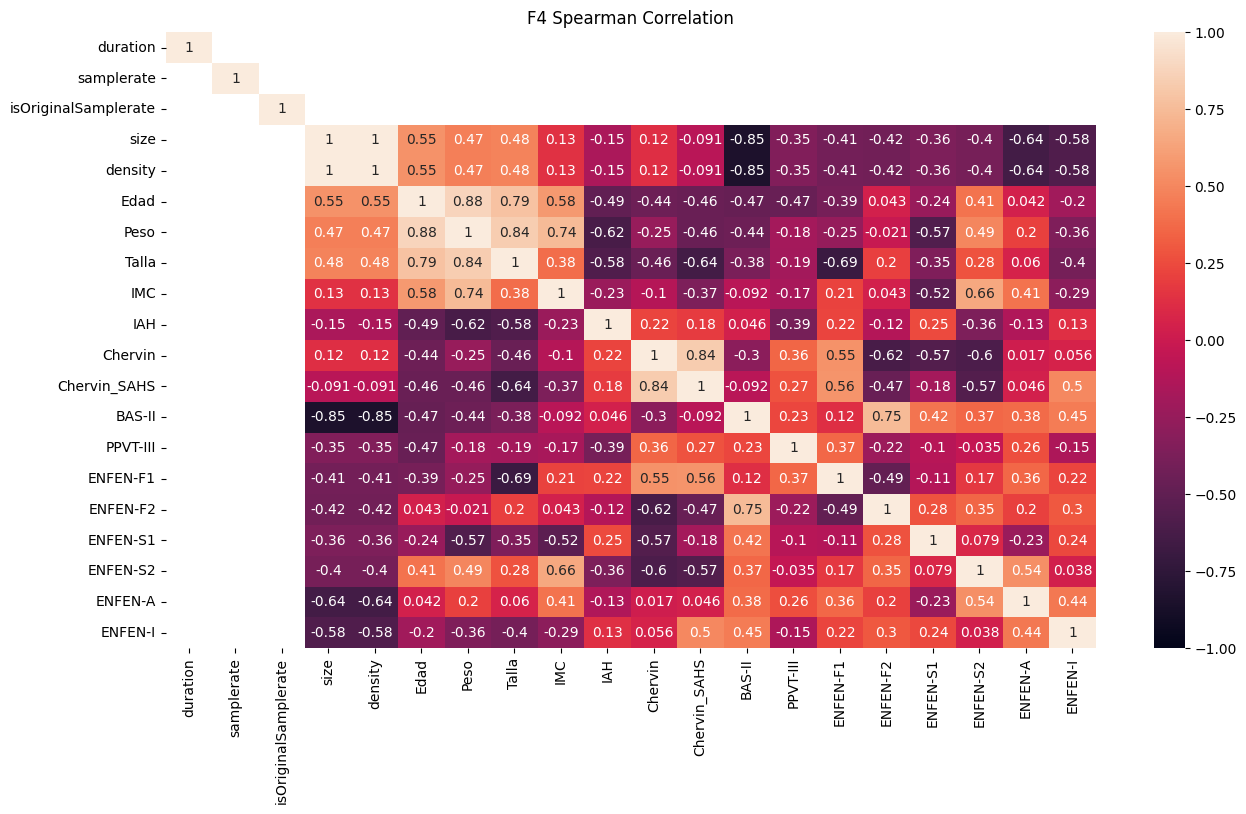

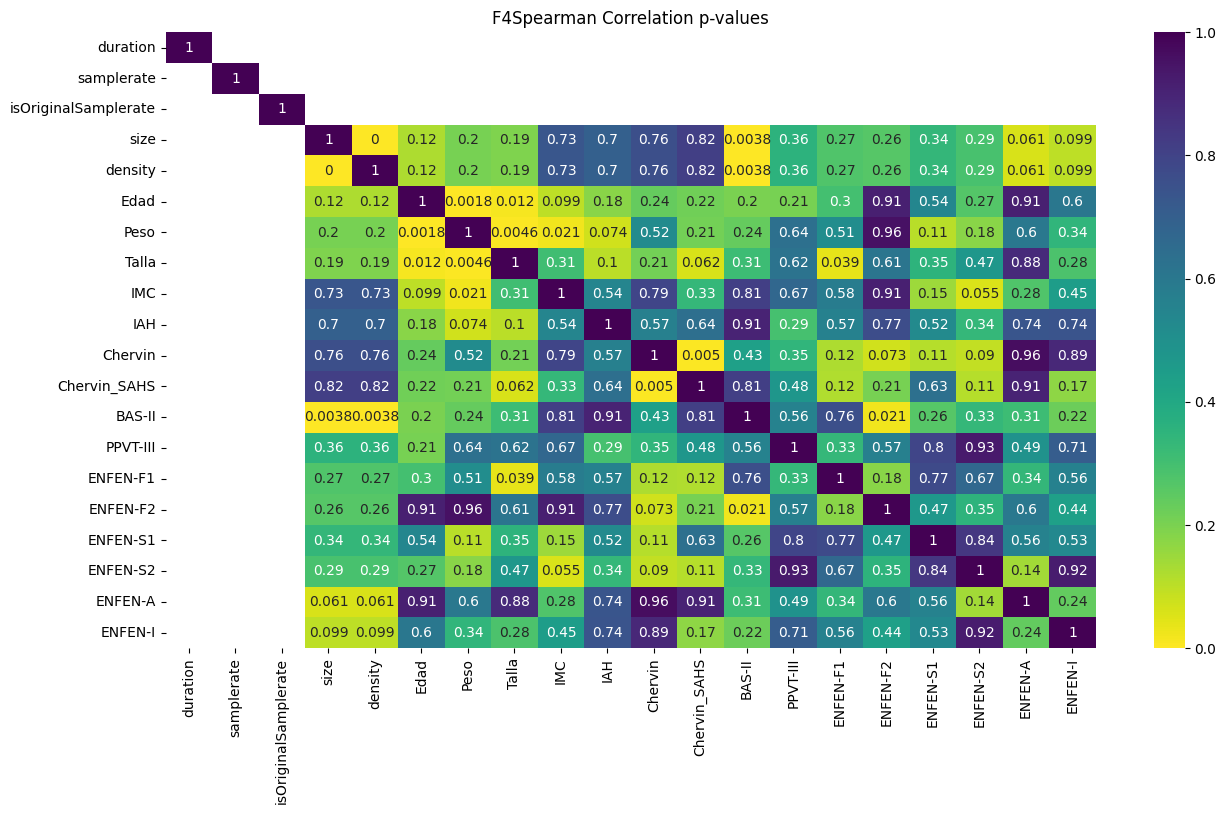

In [71]:
tests=pd.read_csv(cognipath+'/fullTests_3.csv')

for channel,df in aux.groupby('channel'):
    descriptors=pd.merge(df,tests,on='subjectId')
    
    #correlation matrices
    from scipy.stats import spearmanr
    def spearmanr_pval(x,y):
            return spearmanr(x,y)[1]

    def spearmanr_r(x,y):
            return spearmanr(x,y)[0]

    r=descriptors.corr(method=spearmanr_r)
    pval=descriptors.corr(method=spearmanr_pval)

    import seaborn as sns # For pairplots and heatmaps
    plt.figure(figsize=(15,8))
    heatmap = sns.heatmap(r, vmin=-1, vmax=1, annot=True)
    plt.title(channel+" Spearman Correlation")

    plt.figure(figsize=(15,8))
    heatmap = sns.heatmap(pval, vmin=0, vmax=1, annot=True,cmap=plt.cm.get_cmap('viridis_r'))
    plt.title(channel+"Spearman Correlation p-values")

### Spindle density, global

In [35]:
aux=spindles[['subjectId','startTime']].groupby(['subjectId'],as_index=False).size()
aux

,subjectId,size
0,COG001,2283
1,COG002,625
2,COG003,2912
3,COG004,1908
4,COG005,3084
5,COG006,1335
6,COG007,1507
7,COG008,457
8,COG009,578


In [41]:
subjectsMetadata=signalsMetadata[['subjectId','database','duration']].drop_duplicates().reset_index(drop=True)
subjectsMetadata

,subjectId,database,duration
0,COG001,COGNITION_v2,39600.0
1,COG002,COGNITION_v2,39600.0
2,COG003,COGNITION_v2,39600.0
3,COG004,COGNITION_v2,39600.0
4,COG005,COGNITION_v2,39600.0
5,COG006,COGNITION_v2,39600.0
6,COG007,COGNITION_v2,39600.0
7,COG008,COGNITION_v2,39600.0
8,COG009,COGNITION_v2,39600.0
9,COG010,COGNITION_v2,25695.0


In [42]:
aux=pd.merge(subjectsMetadata,aux,on="subjectId")
aux["density"]=aux["size"]/(aux["duration"]/3600)

In [43]:
aux

,subjectId,database,duration,size,density
0,COG001,COGNITION_v2,39600.0,2283,207.545455
1,COG002,COGNITION_v2,39600.0,625,56.818182
2,COG003,COGNITION_v2,39600.0,2912,264.727273
3,COG004,COGNITION_v2,39600.0,1908,173.454545
4,COG005,COGNITION_v2,39600.0,3084,280.363636
5,COG006,COGNITION_v2,39600.0,1335,121.363636
6,COG007,COGNITION_v2,39600.0,1507,137.000000
7,COG008,COGNITION_v2,39600.0,457,41.545455
8,COG009,COGNITION_v2,39600.0,578,52.545455


### Correlations

In [52]:
tests=pd.read_csv(cognipath+'/fullTests_3.csv')
tests

,subjectId,Edad,Peso,Talla,IMC,Fecha_PSG,IAH,Chervin,Chervin_SAHS,BAS-II,PPVT-III,ENFEN-F1,ENFEN-F2,ENFEN-S1,ENFEN-S2,ENFEN-A,ENFEN-I
0,COG001,6.7,28.0,124.0,18.2,28/01/2020,28.4,18.0,1.0,87,100,6,3,4,1,2,5
1,COG002,7.3,31.0,130.0,18.3,04/02/2020,25.2,6.0,0.0,121,98,5,9,6,8,5,7
2,COG003,8.7,40.5,132.0,23.2,25/02/2020,3.0,15.0,1.0,87,103,7,3,3,7,6,7
3,COG004,8.1,36.0,138.0,18.9,26/02/2020,1.6,7.0,0.0,102,108,4,7,5,6,4,4
4,COG005,9.6,33.8,138.0,17.7,04/03/2020,6.6,5.0,0.0,55,89,1,5,7,5,2,6
5,COG006,7.6,28.0,125.0,17.9,05/03/2020,10.9,9.0,1.0,109,96,5,8,7,5,4,10
6,COG007,7.5,32.0,135.0,17.6,10/03/2020,3.0,15.0,1.0,95,101,3,6,3,1,3,7
7,COG008,6.4,17.0,113.0,13.3,11/03/2020,3.7,11.0,1.0,109,112,6,5,8,5,3,7
8,COG009,6.6,23.0,127.0,14.3,12/03/2020,27.4,15.0,1.0,98,107,5,5,6,1,5,7
9,COG010,9.8,55.5,146.0,26.0,23/06/2020,1.0,12.0,1.0,91,102,3,5,3,5,4,2


In [53]:
descriptors=pd.merge(aux,tests,on='subjectId')
descriptors

,subjectId,database,duration,size,density,Edad,Peso,Talla,IMC,Fecha_PSG,...,Chervin,Chervin_SAHS,BAS-II,PPVT-III,ENFEN-F1,ENFEN-F2,ENFEN-S1,ENFEN-S2,ENFEN-A,ENFEN-I
0,COG001,COGNITION_v2,39600.0,2283,207.545455,6.7,28.0,124.0,18.2,28/01/2020,...,18.0,1.0,87,100,6,3,4,1,2,5
1,COG002,COGNITION_v2,39600.0,625,56.818182,7.3,31.0,130.0,18.3,04/02/2020,...,6.0,0.0,121,98,5,9,6,8,5,7
2,COG003,COGNITION_v2,39600.0,2912,264.727273,8.7,40.5,132.0,23.2,25/02/2020,...,15.0,1.0,87,103,7,3,3,7,6,7
3,COG004,COGNITION_v2,39600.0,1908,173.454545,8.1,36.0,138.0,18.9,26/02/2020,...,7.0,0.0,102,108,4,7,5,6,4,4
4,COG005,COGNITION_v2,39600.0,3084,280.363636,9.6,33.8,138.0,17.7,04/03/2020,...,5.0,0.0,55,89,1,5,7,5,2,6
5,COG006,COGNITION_v2,39600.0,1335,121.363636,7.6,28.0,125.0,17.9,05/03/2020,...,9.0,1.0,109,96,5,8,7,5,4,10
6,COG007,COGNITION_v2,39600.0,1507,137.000000,7.5,32.0,135.0,17.6,10/03/2020,...,15.0,1.0,95,101,3,6,3,1,3,7
7,COG008,COGNITION_v2,39600.0,457,41.545455,6.4,17.0,113.0,13.3,11/03/2020,...,11.0,1.0,109,112,6,5,8,5,3,7
8,COG009,COGNITION_v2,39600.0,578,52.545455,6.6,23.0,127.0,14.3,12/03/2020,...,15.0,1.0,98,107,5,5,6,1,5,7


C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_15932\1804215650.py:9: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.

c:\Users\Gurdiel\Code\SpinCo\venv\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

C:\Users\Gurdiel\AppData\Local\Temp\ipykernel_15932\1804215650.py:10: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 1.0, 'Spearman Correlation p-values')

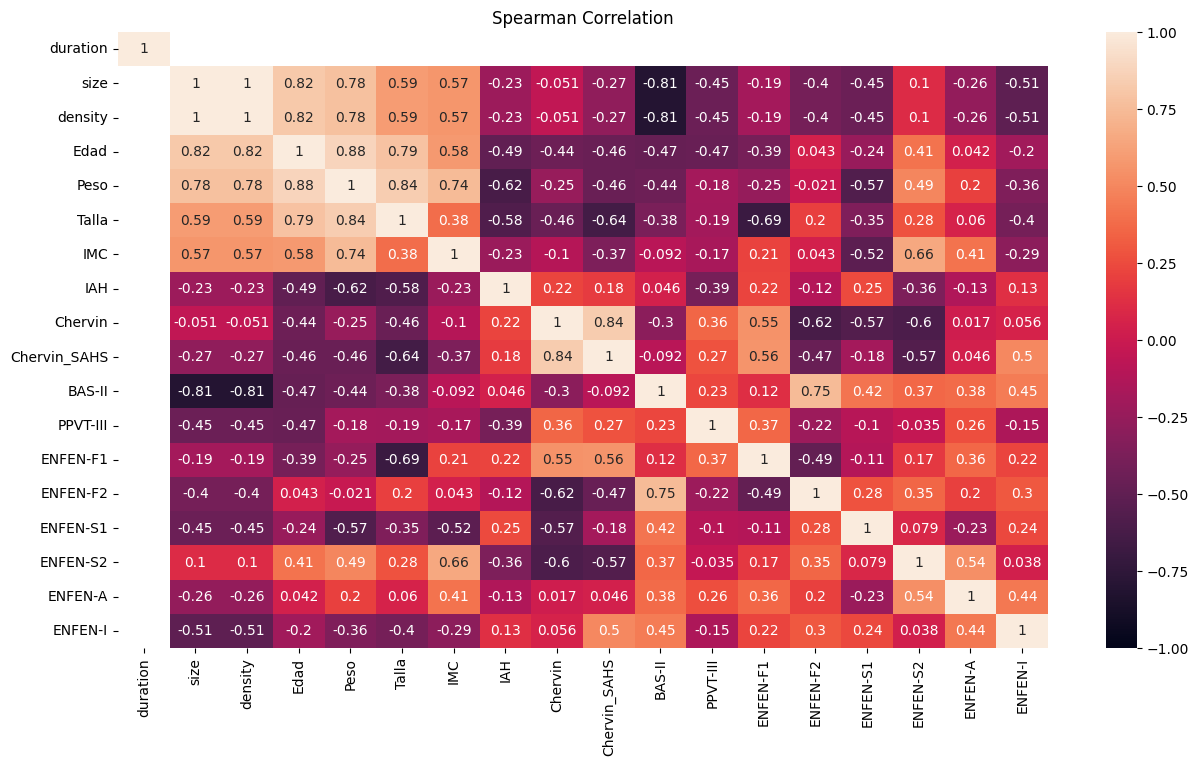

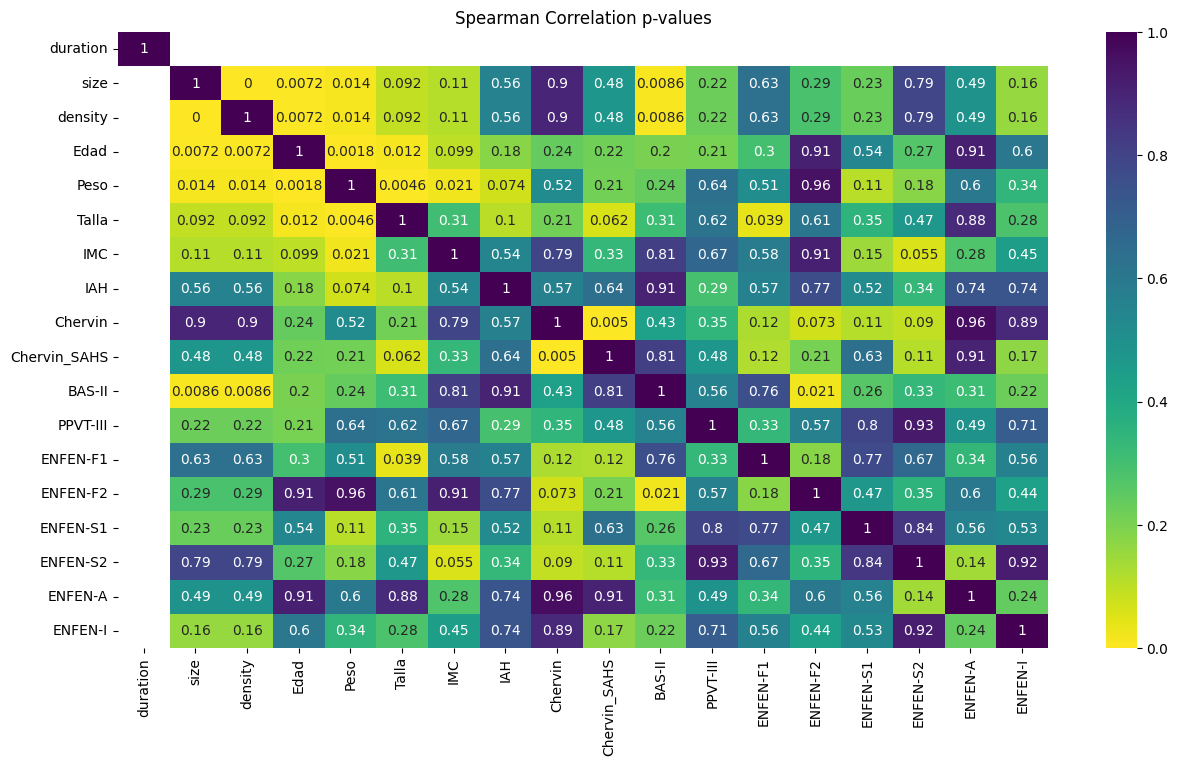

In [54]:
#correlation matrices
from scipy.stats import spearmanr
def spearmanr_pval(x,y):
        return spearmanr(x,y)[1]

def spearmanr_r(x,y):
        return spearmanr(x,y)[0]

r=descriptors.corr(method=spearmanr_r)
pval=descriptors.corr(method=spearmanr_pval)

import seaborn as sns # For pairplots and heatmaps
plt.figure(figsize=(15,8))
heatmap = sns.heatmap(r, vmin=-1, vmax=1, annot=True)
plt.title("Spearman Correlation")

plt.figure(figsize=(15,8))
heatmap = sns.heatmap(pval, vmin=0, vmax=1, annot=True,cmap=plt.cm.get_cmap('viridis_r'))
plt.title("Spearman Correlation p-values")

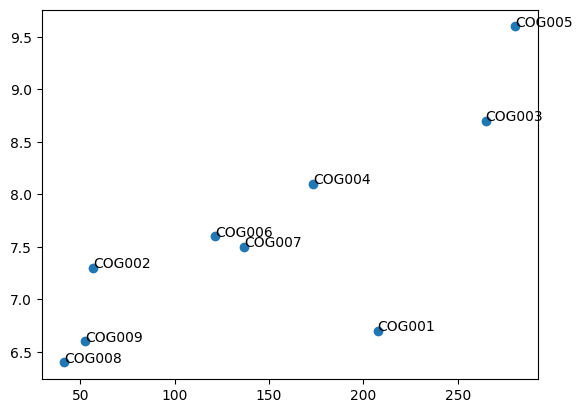

In [56]:
plt.plot(descriptors['density'],descriptors['Edad'],linestyle='',marker='o')
for x,y,text in zip(descriptors['density'],descriptors['Edad'],descriptors['subjectId']):
    plt.annotate(text,(x,y))

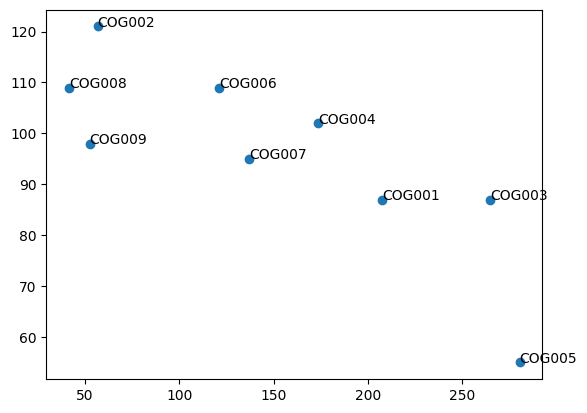

In [59]:
plt.plot(descriptors['density'],descriptors['BAS-II'],linestyle='',marker='o')
for x,y,text in zip(descriptors['density'],descriptors['BAS-II'],descriptors['subjectId']):
    plt.annotate(text,(x,y))